In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

from photon_canon.contrib.bio import wl, eps
from photon_canon.contrib.bio import hemoglobin_mus
from photon_canon.lut import LUT

from hsdfmpm.hsdfm.utils import find_cycles, gabor_filter_bank, mask_by_k_clustering, mask_by_gmm, naive_leastsq_reflectance
from hsdfmpm.utils import apply_kernel_bank, truncate_colormap, colorize
from hsdfmpm.hsdfm import HyperspectralImage, MergedHyperspectralImage
from hsdfmpm.mpm import OpticalRedoxRatio, LifetimeImage, InstrumentResponseFunction


plt.set_cmap('gray')
plt.close('all')

# HSDFM Processing
1. Load standard, background, and data images
2. Normalize all to integration time $ I_{s, i, j}' = I_{s, i, j} / \tau_s $
3. Normalize data to standard and background $ I''_{s, i, j} = \frac{I'_{s, i, j} - I'^{(bg)}_{s, i , j}} {I'^{(std)}_{s, i, j} - I'^{(bg)}_{s, i, j}} $
4. Perform a naive least squares fit to calculate a hemoglobin index
5. Apply a bank of multiscale Gabor filters to the hemoglobin index image
6. Apply an 11 $\times$ 11 adaptive threshold to the Gabor response to create a vascular mask.
7.

In [35]:
# Find raw data
wavelengths = np.arange(500, 730, 10)

# Load normalization data
standard = MergedHyperspectralImage(image_paths=find_cycles(r'D:\Jesse\hsdfmpm_poc\Standards'), scalar=0.8, wavelengths=wavelengths)
standard.normalize_integration_time()
background = MergedHyperspectralImage(image_paths=find_cycles(r'D:\Jesse\hsdfmpm_poc\Background'), wavelengths=wavelengths)
background.normalize_integration_time()

[None, None, None]

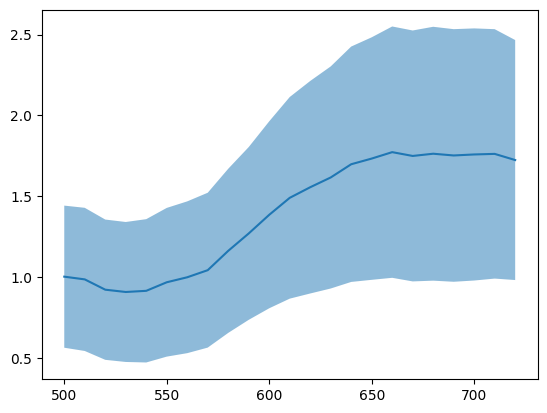

In [36]:
# Load data and normalize
hs = HyperspectralImage(image_path=r'D:\Jesse\hsdfmpm_poc\Animals\1782NT\06072025\100\fov2\cycle2', standard=standard, background=background, wavelengths=wavelengths)
hs.normalize()
means = np.nanmean(hs, axis=(1, 2))
wls = hs.metadata['Wavelength']
plt.plot(wls, means)

stdevs = np.nanstd(hs, axis=(1, 2))
plt.fill_between(wls, means - stdevs, means + stdevs, alpha=0.5)
plt.show()
hs.resize_to(256)

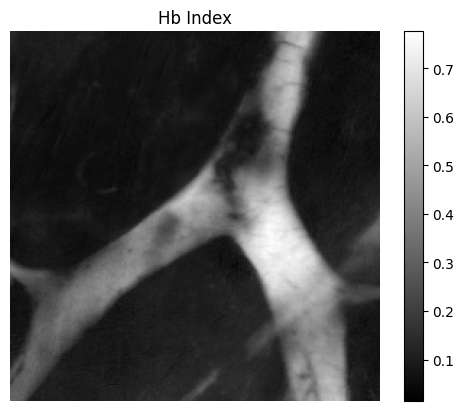

In [37]:
# Get variables for naive fit
sub_wl = np.arange(500, 610, 10)
selected = np.isin(wl, sub_wl)
e = eps[:, selected]

# Fit the image with naive lsq and apply gabor bank
hs.subset_by_metadata('Wavelength', sub_wl)
naive_fit = naive_leastsq_reflectance(hs.image, e)
hb_index = naive_fit[0] + naive_fit[1]
plt.imshow(hb_index)
plt.title('Hb Index')
plt.axis('off')
plt.colorbar()
plt.show()

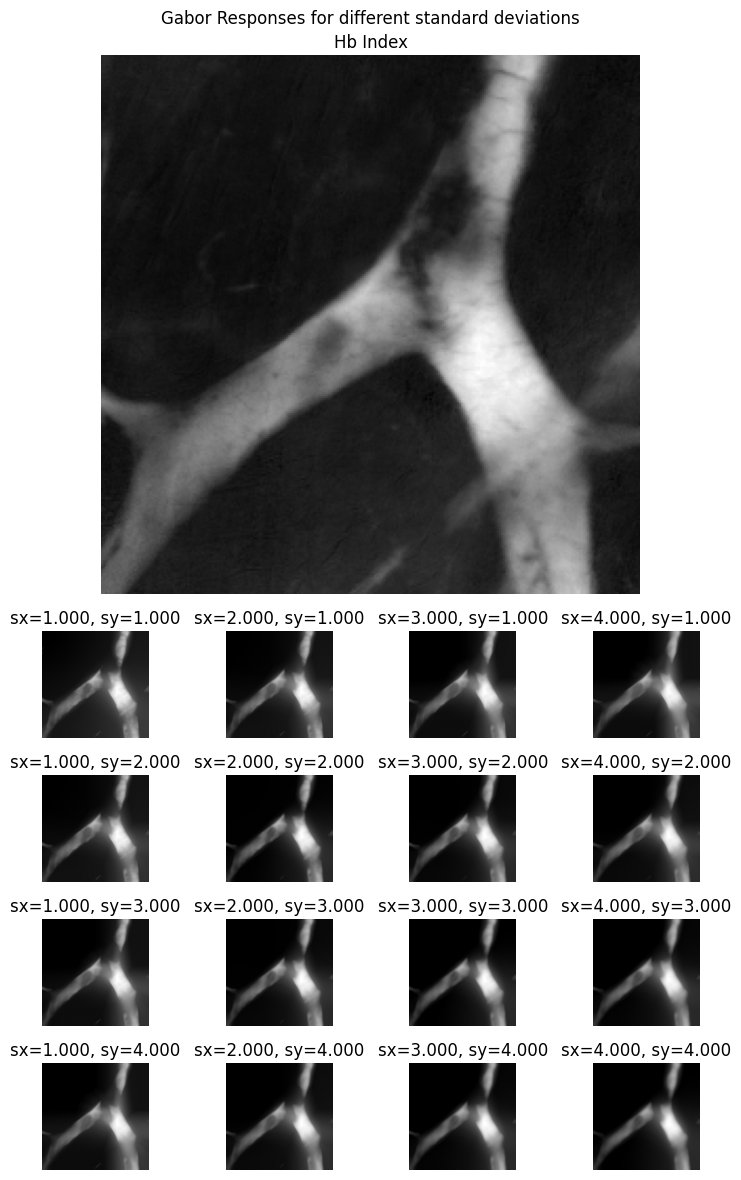

In [38]:
# Compare filter banks
f = np.geomspace(0.01, 1, 16)
fig = plt.figure(figsize=(7.5, 12))
gs = GridSpec(8, 4)
ax = fig.add_subplot(gs[:4, :4])
ax.imshow(hb_index)
ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Hb Index')
fig.suptitle('Gabor Responses for different standard deviations')
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(gs[4 + j, i])
        gabor_bank = gabor_filter_bank(frequency=f, sigma_x=(i+1)/f, sigma_y=(j+1)/f)
        gabor_response = apply_kernel_bank(hb_index, gabor_bank)
        ax.set_title(f'sx={(i+1):.3f}, sy={(j+1):.3f}')
        ax.imshow(gabor_response)
        ax.axis('off')
        ax.set_aspect('equal')
plt.tight_layout()
plt.show()

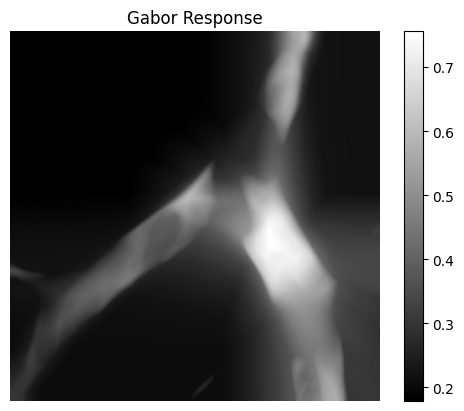

In [39]:
# Apply chosen Gabor design
f = np.geomspace(0.01, 1, 16)
gabor_response = apply_kernel_bank(hb_index, gabor_filter_bank(frequency=f, sigma_x=4/f, sigma_y=1/f))
plt.imshow(gabor_response)
plt.title('Gabor Response')
plt.axis('off')
plt.colorbar()
plt.show()

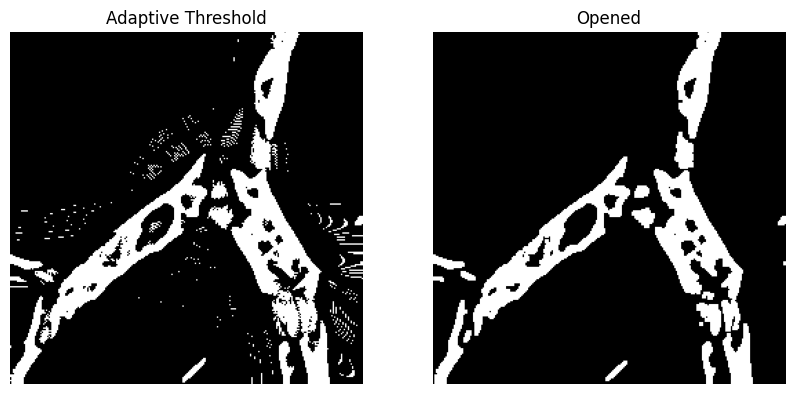

In [40]:
mask = cv2.adaptiveThreshold((gabor_response / gabor_response.max() * 255).astype(np.uint8), 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(mask)
ax[0].axis('off')
ax[0].set_title('Adaptive Threshold')

mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3)))
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].set_title('Opened')
plt.show()

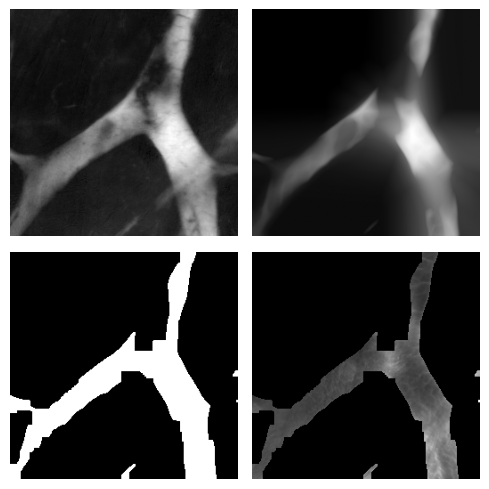

In [46]:
# Apply conditional masking
mask = cv2.morphologyEx(
    cv2.morphologyEx(
    cv2.adaptiveThreshold((255 * gabor_response / gabor_response.max()).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0),
    cv2.MORPH_OPEN, np.ones((3, 3))
), cv2.MORPH_CLOSE, np.ones((15, 15))
).astype(bool)

fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for a in ax.flatten():
    a.axis('off')
ax[0, 0].imshow(hb_index)
ax[0, 1].imshow(gabor_response)
ax[1, 0].imshow(mask)
ax[1, 1].imshow(np.mean(hs.image * mask, axis=0))
plt.tight_layout()
plt.show()

C:\Users\jdivers\AppData\Local\Temp\ipykernel_15552\1724340579.py:5: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(in_data, axis=0))


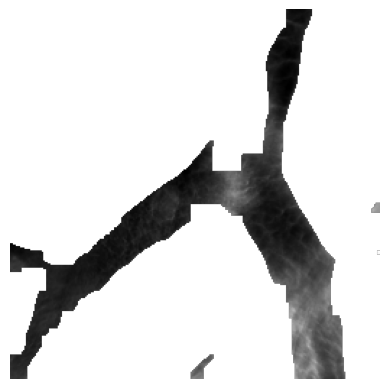

C:\Users\jdivers\AppData\Local\Temp\ipykernel_15552\1724340579.py:8: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(out_data, axis=0))


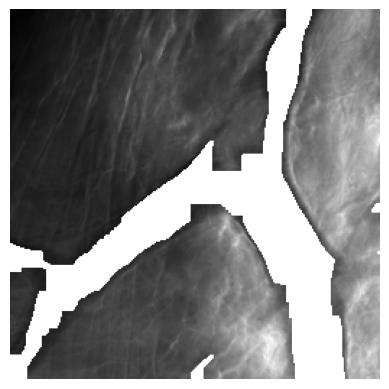

In [47]:
in_data = hs.image * mask
out_data = hs.image * ~mask
in_data[:, ~mask] = np.nan
out_data[:, mask] = np.nan
plt.imshow(np.nanmean(in_data, axis=0))
plt.axis('off')
plt.show()
plt.imshow(np.nanmean(out_data, axis=0))
plt.axis('off')
plt.show()

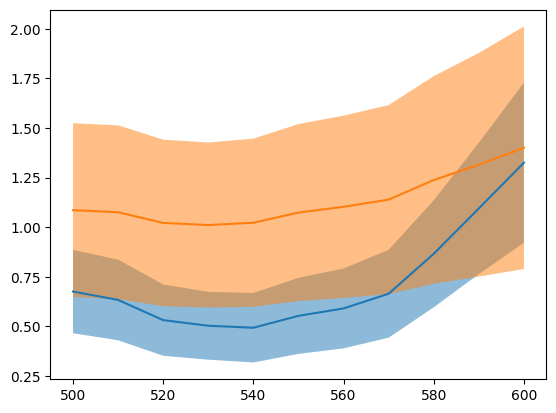

In [48]:
wls = sub_wl
in_means = np.nanmean(in_data, axis=(1, 2))
out_means = np.nanmean(out_data, axis=(1, 2))
plt.plot(wls, in_means)
plt.plot(wls, out_means)

in_stdevs = np.nanstd(in_data, axis=(1, 2))
out_stdevs = np.nanstd(out_data, axis=(1, 2))
plt.fill_between(wls, in_means - in_stdevs, in_means + in_stdevs, alpha=0.5)
plt.fill_between(wls, out_means - out_stdevs, out_means + out_stdevs, alpha=0.5)
plt.show()

In [54]:
out_data[:, i, j]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
from tqdm import tqdm
from hsdfmpm.hsdfm.fit import fit_voxel
g = 0.9
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True, simulation_id=88)
wavelengths = np.arange(500, 610, 10)
def scatter_model(a, b):
    mu_s, mu_a, _ = hemoglobin_mus(a, b, 0, 0.5, wavelengths, force_feasible=False)
    mu_s /= (1 - g)
    r = lut(mu_s, mu_a)
    return r

rng = np.random.default_rng(42)
i, j = rng.integers(low=0, high=256, size=2)
param_image = []
chi_sq = []
for _ in tqdm(range(0, 50)):
    while np.all(np.isnan(out_data[:, i, j])):
        i, j = rng.integers(low=0, high=256, size=2)
    pi, cs = fit_voxel(
        out_data[:, i, j],
        model=scatter_model,
        x0=[1, 1],
        bounds=[(0, 0), (np.inf, np.inf)],
        max_nfev=5000
    )
    param_image.append(pi)
    chi_sq.append(cs)

In [63]:
a, b = np.mean(param_image, axis=0)

In [64]:
def model(t, s):
    mu_s, mu_a, _ = hemoglobin_mus(a, b, t, s, wavelengths, force_feasible=False)
    mu_s /= (1 - g)
    r = lut(mu_s, mu_a, extrapolate=True)
    return r

In [65]:
param_image, chi_sq = hs.fit(
        model,
        x0=[0.5, 0.5],
        bounds=[(0, 0), (np.inf, 1)],
        use_multiprocessing=False,
        max_nfev=5000)
thb, so2 = param_image

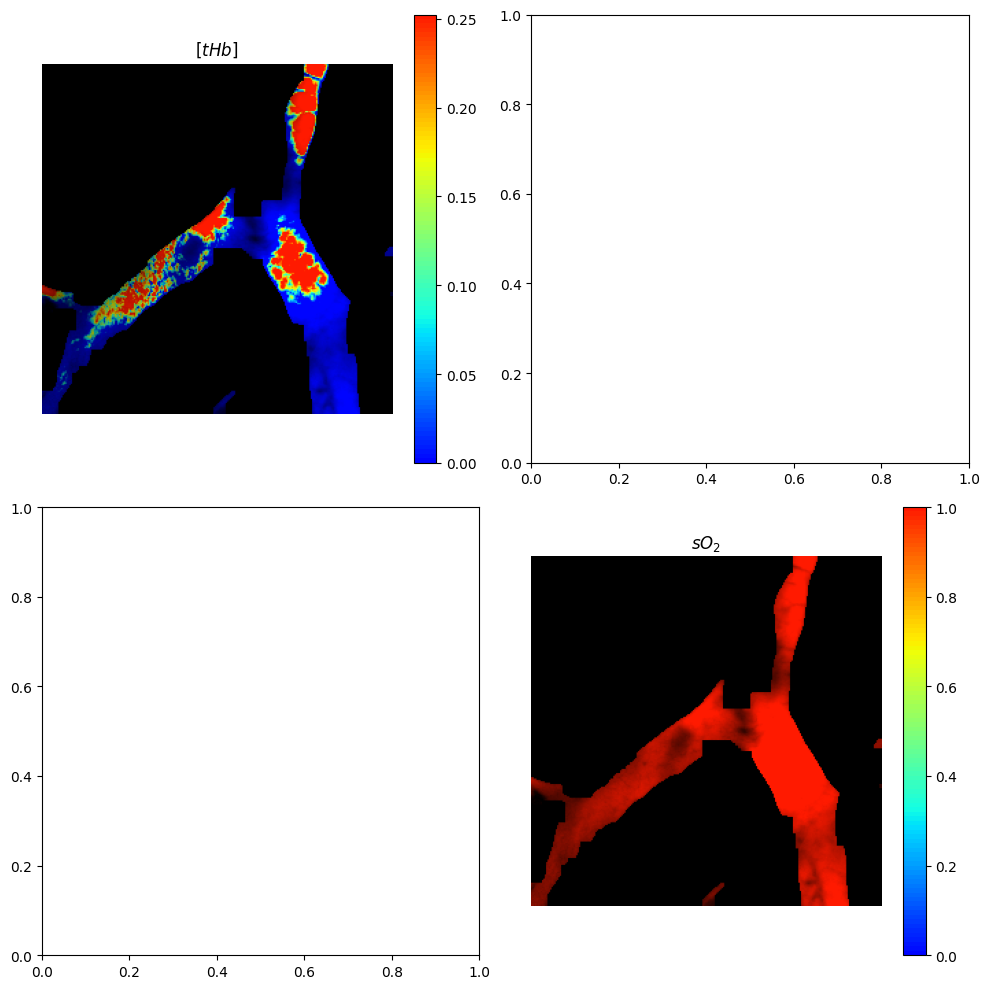

In [66]:
# Create color maps
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for png_name, im, ax in zip(['[tHb]'], [thb], axes.flat):
    im[~mask] = np.nan
    cmin, cmax = np.nanmean(im[mask]) + np.array([-1, 1]) * np.nanstd(im[mask])
    cmin = max(0, cmin)
    color_var, cmap = colorize(im, hb_index, cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.axis('off')
    ax.set_title(f'${png_name}$')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
ax = axes[1, 1]
im = so2.copy()
im[~mask] = np.nan
cmin, cmax = 0, 1
cmin = max(0, cmin)
color_var, cmap = colorize(im, hb_index, cmap=cmap, cmin=cmin, cmax=cmax)
ax.imshow(color_var, cmap=cmap)
ax.axis('off')
ax.set_title(f'$sO_2$')
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
plt.colorbar(sm, ax=ax)

plt.tight_layout()

# ORR

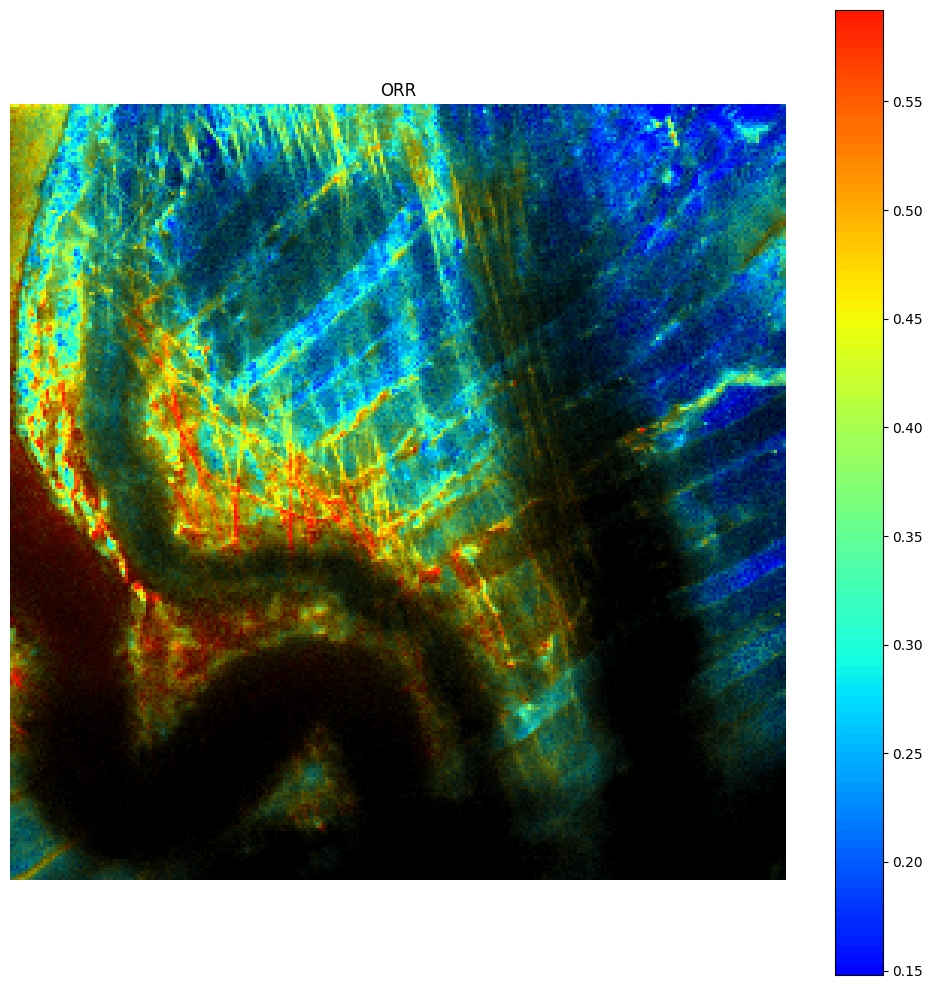

In [72]:
# Load images
orr = OpticalRedoxRatio(
    ex755=r'E:\new df\POC Study\Animals\1675NT\03302025\100\fov2\fov2_redox_755-088',
    ex855=r'E:\new df\POC Study\Animals\1675NT\03302025\100\fov2\fov2_redox_855-089',
    power_file_path=r'E:\new df\POC Study\LaserPower')

# Down sample for SNR and to match HSDFM
orr.resize_to(256)

# Create outputs
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
cmin, cmax = np.mean(orr.map) + np.array([-2, 2]) * np.std(orr.map)
color_orr, cmap = orr.colorize(cmap=cmap, cmin=cmin, cmax=cmax)
fig = plt.figure(figsize=(10, 10))
plt.imshow(color_orr, cmap=cmap)
ax = plt.gca()
ax.set_title('ORR')
ax.axis('off')
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
plt.colorbar(sm, ax=ax)
plt.tight_layout()

# FLIM

C:\Users\jdivers\PycharmProjects\hsdfmpm\src\hsdfmpm\mpm\flim\flim.py:75: Warning: Loading default IRF file, 'C:\Users\jdivers\.hsdfmpm\irf\irf.pkl'.
  self.calibration = get_irf(irf)


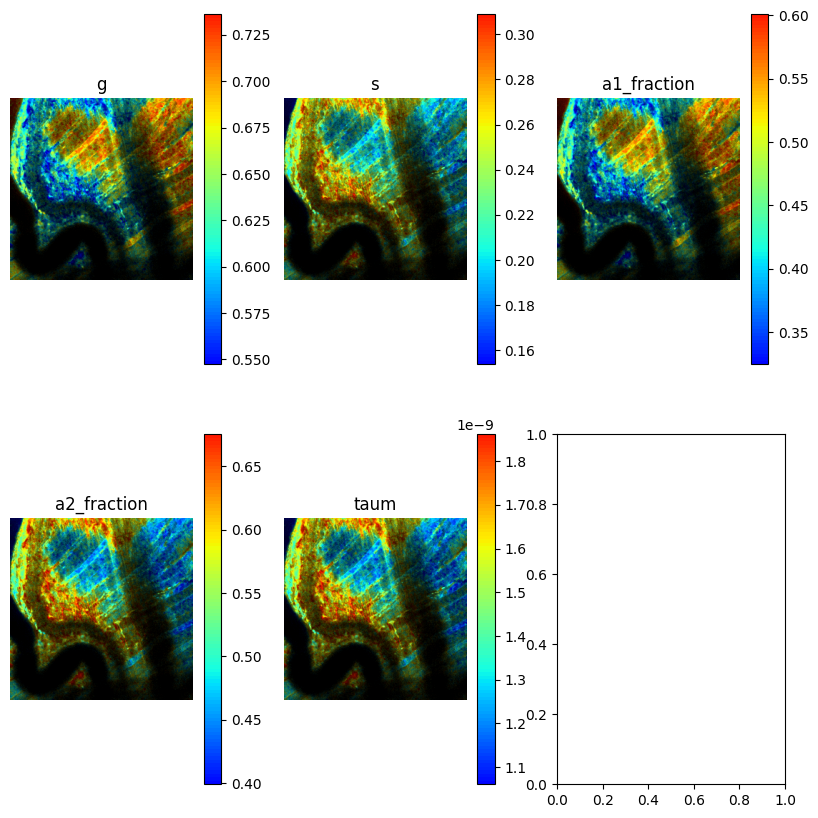

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [74]:
decay = LifetimeImage(image_path=r'E:\new df\POC Study\Animals\1675NT\03302025\100\fov2\fov2_flim_755-087', channels=0)
decay.load_irf()  # IRF was previously stored
decay.resize_to(256)

# Calculate phasor coords and fit-line endpoints
g, s = decay.phasor_coordinates(threshold=10, median_filter_count=1, k_size=3, correction=True)
alphas, taum, tau = decay.fit_for_lifetime_approximations(median_filter_count=1, k_size=3)
a2_fraction = alphas[1] / (alphas[0] + alphas[1])
a1_fraction = alphas[0] / (alphas[0] + alphas[1])

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for png_name, im, ax in zip(['g', 's', 'a1_fraction', 'a2_fraction', 'taum'], [g, s, a1_fraction, a2_fraction, taum], axes.flat):
    cmin, cmax = np.mean(im) + np.array([-2, 2]) * np.std(im)
    color_var, cmap = colorize(im.squeeze(), np.nansum(decay.decay, axis=-1).squeeze(), cmap=cmap, cmin=cmin, cmax=cmax)
    fig = plt.figure(figsize=(10, 10))
    ax.imshow(color_var, cmap=cmap)
    ax.set_title(f'{png_name}')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
plt.tight_layout()
plt.show()

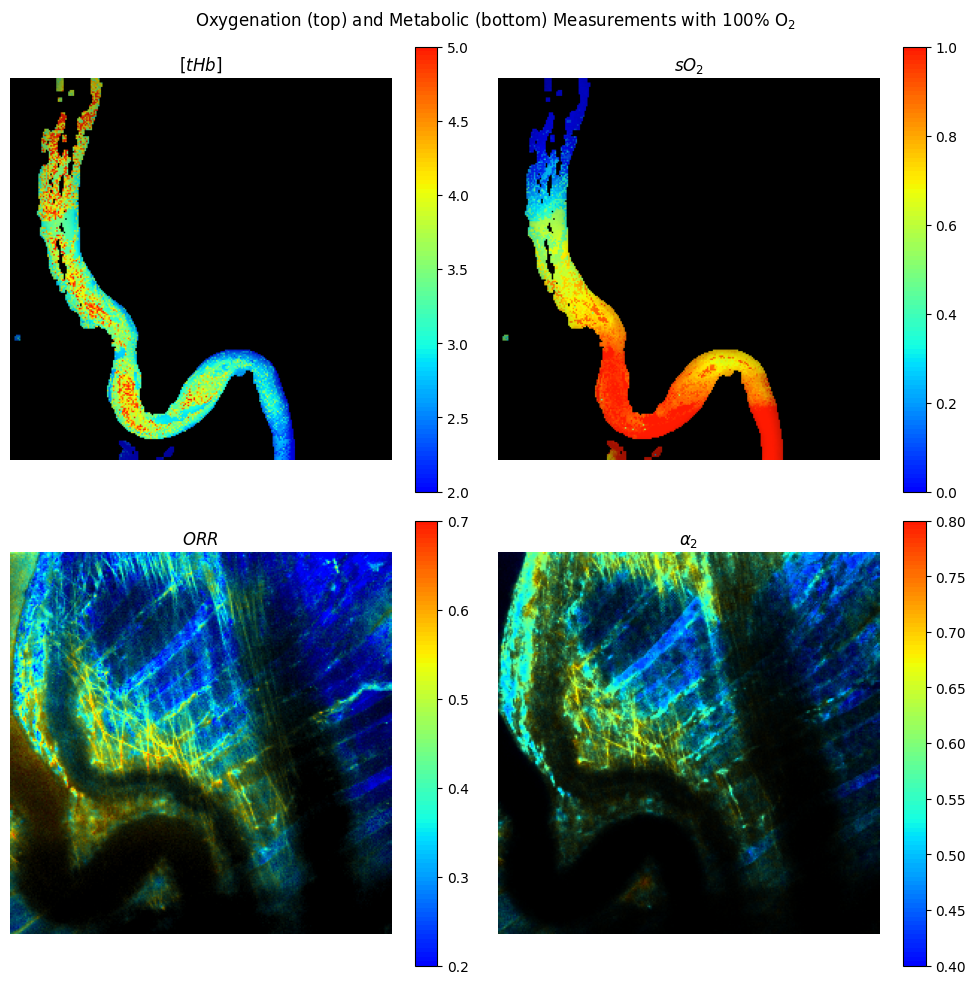

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Oxygenation (top) and Metabolic (bottom) Measurements with 100% O$_2$')
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
for name, varim, intim,  ax, (cmin, cmax) in zip(
    ['[tHb]', 'sO_2', 'ORR', r'\alpha_2'],
    [thb, so2, orr.map, a2_fraction],
    [(hb_index * mask).squeeze(), (hb_index * mask).squeeze(), ((orr.fad + orr.nadh) / 2).squeeze(), (np.nansum(decay, axis=-1) * np.nansum(decay, axis=-1)).squeeze()],
    axes.flat,
    [(2, 5), (0, 1), (0.2, 0.7), (0.4, 0.8)]
):
    color_var, cmap = colorize(varim, intim, cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.set_title(f'${name}$')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
plt.tight_layout()
plt.show()